# Package Impoting

In [1]:
!pip install datasets accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00


In [2]:
# Import necessary packages
from sklearn.metrics import accuracy_score
from transformers import default_data_collator, get_scheduler
from accelerate import Accelerator
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
import collections
import evaluate
from tqdm.auto import tqdm
import json

2024-06-14 08:11:41.531833: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 08:11:41.531942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 08:11:41.668525: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Importing packages
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so

import transformers

import torch
import torch.nn as nn  # Neural networks
import torch.optim as optim  # Optimizers
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch.optim import AdamW

from datasets import load_dataset

import json

from sklearn.metrics import accuracy_score

from accelerate import Accelerator

import collections
import evaluate



from transformers import BertTokenizer, BertModel, BertForQuestionAnswering, AutoModel
from transformers.modeling_outputs import QuestionAnsweringModelOutput
from transformers import default_data_collator, get_scheduler

# Functions

In [4]:
def compute_lacc(predictions, references):
    correct_start = 0
    correct_end = 0
    total = 0
    
    for pred, ref in zip(predictions, references):
        pred_start = pred['prediction_start']
        pred_end = pred['prediction_end']
        ref_start = ref['answers'][0]['answer_start']
        ref_end = ref['answers'][0]['answer_start'] + len(ref['answers'][0]['text'])

        if pred_start == ref_start:
            correct_start += 1
        if pred_end == ref_end:
            correct_end += 1
        total += 1
    
    lacc = (correct_start + correct_end) / (2 * total)
    return lacc

def compute_sacc(predictions, references):
    correct_sequences = 0
    total = 0
    
    for pred, ref in zip(predictions, references):
        pred_text = pred['prediction_text']
        ref_text = ref['answers'][0]['text']
        
        if pred_text == ref_text:
            correct_sequences += 1
        total += 1
    
    sacc = correct_sequences / total
    return sacc


In [5]:
def compute_mrr(predictions, references):
    reciprocal_ranks = []
    for pred, ref in zip(predictions, references):
        if ref["answers"]:
            correct_answers = [a["text"] for a in ref["answers"]]
            try:
                rank = next(i + 1 for i, p in enumerate(pred["prediction_text"]) if p in correct_answers)
                reciprocal_ranks.append(1.0 / rank)
            except StopIteration:
                reciprocal_ranks.append(0.0)
    return np.mean(reciprocal_ranks)

In [6]:
def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in examples:
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                        "prediction_start": offsets[start_index][0],
                        "prediction_end": offsets[end_index][1],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"],
                 "prediction_start": best_answer["prediction_start"], "prediction_end": best_answer["prediction_end"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": "", "prediction_start": -1, "prediction_end": -1})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    metrics = metric.compute(predictions=[{"id": p["id"], "prediction_text": p["prediction_text"]} for p in predicted_answers],
                             references=theoretical_answers)
    
    # Calculate Lacc and Sacc
    metrics['mrr'] = compute_mrr(predicted_answers, theoretical_answers)
    metrics['lacc'] = compute_lacc(predicted_answers, theoretical_answers)
    metrics['sacc'] = compute_sacc(predicted_answers, theoretical_answers)
    
    return metrics

# Model Checkpoint

In [7]:
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering

model_checkpoint = "dmis-lab/biobert-v1.1"
# model_checkpoint = "michiyasunaga/BioLinkBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = BertForQuestionAnswering.from_pretrained(model_checkpoint)
# model_base = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# ner_model = BertForQuestionAnswering.from_pretrained('/kaggle/input/biobert-ner-finetuned/pytorch/biobert-ner-finetuned-slug/1/biobert_model_ner')
re_model = BertForQuestionAnswering.from_pretrained('/kaggle/input/bionert-re-finetuned/pytorch/biobert-re-finetuned-slug/1/biobert_model_re')

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at /kaggle/input/bionert-re-finetuned/pytorch/biobert-re-finetuned-slug/1/biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# model.bert = ner_model.bert
model.bert = re_model.bert

In [10]:
pwd

'/kaggle/working'

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

# Data Load & Split

In [12]:

from sklearn.model_selection import train_test_split
from datasets import Dataset

# Load your JSON data
with open('/kaggle/input/bioasq4b-factoid/BioASQ-train-factoid-4b.json', 'r') as f:
    data = json.load(f)

# Flatten the JSON structure and extract the required features
processed_data = []
for item in data['data']:
    for paragraph in item['paragraphs']:
        for qa in paragraph['qas']:
            processed_data.append({
                'id': qa['id'],
                'question': qa['question'],
                'answers': qa['answers'],
                'context': paragraph['context']
            })

# Splitting the processed data into train and test sets
train_data, val_data = train_test_split(processed_data, test_size=0.2, random_state=42)

# Create Dataset objects for train and test sets
raw_train_dataset = Dataset.from_dict({'id': [item['id'] for item in train_data],
                                   'question': [item['question'] for item in train_data],
                                   'answers': [item['answers'] for item in train_data],
                                   'context': [item['context'] for item in train_data]})

raw_val_dataset = Dataset.from_dict({'id': [item['id'] for item in val_data],
                                  'question': [item['question'] for item in val_data],
                                  'answers': [item['answers'] for item in val_data],
                                  'context': [item['context'] for item in val_data]})

# Print information about the train and test datasets
print("Train Dataset:")
print(raw_train_dataset)
print("\nTest Dataset:")
print(raw_val_dataset)


Train Dataset:
Dataset({
    features: ['id', 'question', 'answers', 'context'],
    num_rows: 2612
})

Test Dataset:
Dataset({
    features: ['id', 'question', 'answers', 'context'],
    num_rows: 654
})


In [13]:
raw_train_dataset.filter(lambda x: len(x["answers"][0]["text"]) != 1)
raw_val_dataset.filter(lambda x: len(x["answers"][0]["text"]) != 1)

Filter:   0%|          | 0/2612 [00:00<?, ? examples/s]

Filter:   0%|          | 0/654 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'question', 'answers', 'context'],
    num_rows: 632
})

# Data Pre-processing

In [14]:
max_length = 512
stride = 256


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx][0]
        start_char = answer["answer_start"]
        end_char = answer["answer_start"] + len(answer["text"])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [15]:
train_dataset = raw_train_dataset.map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_train_dataset.column_names,
)
len(raw_train_dataset), len(train_dataset)

Map:   0%|          | 0/2612 [00:00<?, ? examples/s]

(2612, 3247)

In [16]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [17]:
validation_dataset = raw_val_dataset.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_val_dataset.column_names,
)
len(raw_val_dataset), len(validation_dataset)

Map:   0%|          | 0/654 [00:00<?, ? examples/s]

(654, 830)

In [18]:
validation_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 830
})

# Data Post-processing

# Combined model

# Training Loop

In [19]:
# from torch.utils.data import DataLoader
# from transformers import default_data_collator

train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

# Batch customizing ---->
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=16
)

In [20]:
# lr customizing --->
optimizer = AdamW(model.parameters(), lr=2e-5)

In [21]:


accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [22]:
# epoch customizing ---->

num_train_epochs = 10
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [23]:
# import collections


In [24]:
# customizing some Parameters ---->

n_best = 20
max_answer_length = 30

In [25]:
# import evaluate

metric = evaluate.load("squad")

  0%|          | 0/2030 [00:00<?, ?it/s]

Train -->

Evaluation <--


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 0 Metrics:
Training Loss: 2.6211912523349516
EM: 79.81651376146789
F1: 82.93122296985163
MRR: 0.03211009174311927
Lacc: 0.514525993883792
Sacc: 0.7262996941896025
Train -->

Evaluation <--


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1 Metrics:
Training Loss: 1.1767379896981376
EM: 79.81651376146789
F1: 81.77704585237178
MRR: 0.03287461773700306
Lacc: 0.5122324159021406
Sacc: 0.7431192660550459
Train -->

Evaluation <--


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2 Metrics:
Training Loss: 0.9447221544575809
EM: 84.5565749235474
F1: 85.99540070870347
MRR: 0.03287461773700306
Lacc: 0.503822629969419
Sacc: 0.7798165137614679
Train -->

Evaluation <--


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3 Metrics:
Training Loss: 0.843489142914711
EM: 79.96941896024465
F1: 81.87730392870705
MRR: 0.03287461773700306
Lacc: 0.49311926605504586
Sacc: 0.7553516819571865
Train -->

Evaluation <--


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4 Metrics:
Training Loss: 0.7743198852527318
EM: 80.73394495412845
F1: 82.0032531129401
MRR: 0.03287461773700306
Lacc: 0.48394495412844035
Sacc: 0.7660550458715596
Train -->

Evaluation <--


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5 Metrics:
Training Loss: 0.7278452293919813
EM: 84.40366972477064
F1: 85.46562916705928
MRR: 0.03287461773700306
Lacc: 0.48394495412844035
Sacc: 0.7691131498470948
Train -->

Evaluation <--


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6 Metrics:
Training Loss: 0.6983299802970416
EM: 80.42813455657492
F1: 82.04119257748506
MRR: 0.03287461773700306
Lacc: 0.481651376146789
Sacc: 0.7629969418960245
Train -->

Evaluation <--


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7 Metrics:
Training Loss: 0.6760822597689229
EM: 80.58103975535168
F1: 82.06659955243335
MRR: 0.03287461773700306
Lacc: 0.47629969418960244
Sacc: 0.77217125382263
Train -->

Evaluation <--


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8 Metrics:
Training Loss: 0.6547194518185602
EM: 81.03975535168196
F1: 82.56354144845781
MRR: 0.03287461773700306
Lacc: 0.4793577981651376
Sacc: 0.7660550458715596
Train -->

Evaluation <--


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9 Metrics:
Training Loss: 0.6388634551188042
EM: 81.03975535168196
F1: 82.50237936894709
MRR: 0.03287461773700306
Lacc: 0.4793577981651376
Sacc: 0.7660550458715596
EM - Highest: 84.5565749235474, Lowest: 79.81651376146789, Average: 81.23853211009174
F1 - Highest: 85.99540070870347, Lowest: 81.77704585237178, Average: 82.92235686869567
MRR - Highest: 0.03287461773700306, Lowest: 0.03211009174311927, Average: 0.032798165137614674
Lacc - Highest: 0.514525993883792, Lowest: 0.47629969418960244, Average: 0.4908256880733945
Sacc - Highest: 0.7798165137614679, Lowest: 0.7262996941896025, Average: 0.760703363914373


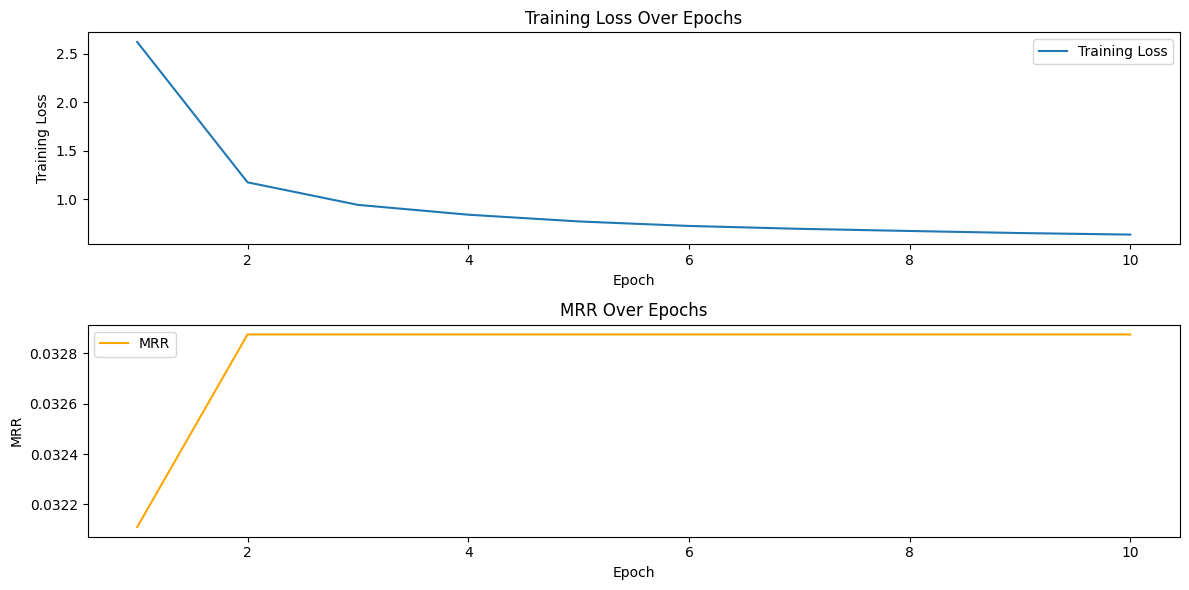

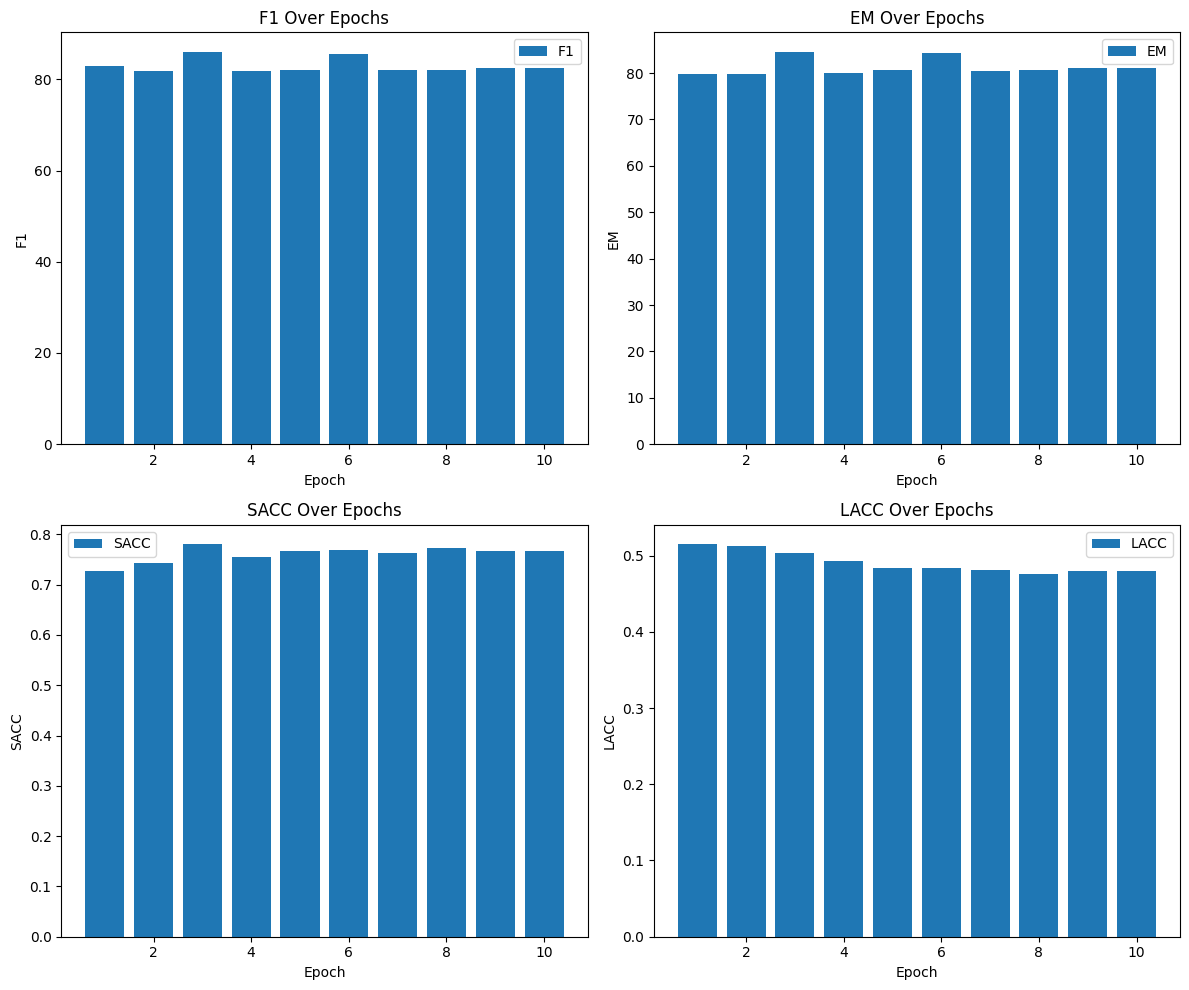

In [26]:
# Assuming these lists exist to hold metrics for each epoch
train_losses = []
em_scores = []
f1_scores = []
mrr_scores = []
lacc_scores = []
sacc_scores = []

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    total_train_loss = 0
    accelerator.print("Train -->")
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    average_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(average_train_loss)

    # Evaluation
    model.eval()
    start_logits = []
    end_logits = []
    accelerator.print("\nEvaluation <--")
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics = compute_metrics(start_logits, end_logits, validation_dataset, raw_val_dataset)

    # Append metrics
    em_scores.append(metrics['exact_match'])
    f1_scores.append(metrics['f1'])
    mrr_scores.append(metrics['mrr'])
    lacc_scores.append(metrics['lacc'])
    sacc_scores.append(metrics['sacc'])

    # Print metrics
    print(f"Epoch {epoch} Metrics:")
    print(f"Training Loss: {average_train_loss}")
    print(f"EM: {metrics['exact_match']}")
    print(f"F1: {metrics['f1']}")
    print(f"MRR: {metrics['mrr']}")
    print(f"Lacc: {metrics['lacc']}")
    print(f"Sacc: {metrics['sacc']}")

# After training, compute highest, lowest, and average scores
def compute_statistics(scores):
    return {
        'highest': np.max(scores),
        'lowest': np.min(scores),
        'average': np.mean(scores)
    }

metrics_statistics = {
    'EM': compute_statistics(em_scores),
    'F1': compute_statistics(f1_scores),
    'MRR': compute_statistics(mrr_scores),
    'Lacc': compute_statistics(lacc_scores),
    'Sacc': compute_statistics(sacc_scores),
}

# Print statistics
for metric, stats in metrics_statistics.items():
    print(f"{metric} - Highest: {stats['highest']}, Lowest: {stats['lowest']}, Average: {stats['average']}")

# Visualizations
epochs = range(1, num_train_epochs + 1)

# Line graphs for training loss and MRR
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, mrr_scores, label='MRR', color='orange')
plt.xlabel('Epoch')
plt.ylabel('MRR')
plt.title('MRR Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# customizing ---->

# Save line chart as 300dpi image --->
plt.savefig('/kaggle/working//biobert_re_qa_finetuning_line_chart.jpg', dpi=300)
plt.close()  # Close the figure to avoid memory issues

# Bar charts for F1, EM, SACC, LACC
metrics = ['F1', 'EM', 'SACC', 'LACC']
metrics_scores = [f1_scores, em_scores, sacc_scores, lacc_scores]

plt.figure(figsize=(12, 10))
for i, (metric, scores) in enumerate(zip(metrics, metrics_scores)):
  plt.subplot(2, 2, i + 1)
  plt.bar(epochs, scores, label=metric)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.title(f'{metric} Over Epochs')
  plt.legend()

plt.tight_layout()
plt.show()

# customizing ---->

# Save bar chart as 300dpi image --->
plt.savefig('/kaggle/working/biobert_re_qa_finetuning_bar_chart.jpg', dpi=300)
plt.close()  # Close the figure to avoid memory issues



In [27]:
pwd

'/kaggle/working'

In [28]:
# save path customizing ---->

model.save_pretrained("/kaggle/working/biobert_re_qa_finetuned")
tokenizer.save_pretrained("/kaggle/working/biobert_re_qa_finetuned")

('/kaggle/working/biobert_re_qa_finetuned/tokenizer_config.json',
 '/kaggle/working/biobert_re_qa_finetuned/special_tokens_map.json',
 '/kaggle/working/biobert_re_qa_finetuned/vocab.txt',
 '/kaggle/working/biobert_re_qa_finetuned/added_tokens.json',
 '/kaggle/working/biobert_re_qa_finetuned/tokenizer.json')

In [29]:
# customiznig ---->


from transformers import pipeline, AutoModelForQuestionAnswering, AutoTokenizer

# Load your saved model checkpoint
biobert_re_qa_finetuned = "/kaggle/working/biobert_re_qa_finetuned"  # Update this with the path to your saved model directory



# Create the question answering pipeline
question_answerer = pipeline("question-answering", model=biobert_re_qa_finetuned, tokenizer=biobert_re_qa_finetuned)

# People with diabetes experience blurry vision because of what?
# What are the symptoms of blurry vision for diabetes people?
# Diabetes is a chronic, long-term, incurable, but controllable condition. Diabetes mellitus (DM) is a group of metabolic disorders characterized by hyperglycemia that results from defects in insulin secretion, insulin action, or both. People who have diabetes often experience a variety of symptoms, including blurry vision, excessive thirst, fatigue, frequent urination, hunger, and weight loss. This review article includes a discussion on diabetes types, symptoms, diagnostic tests, and various therapies for treating, controlling, and managing blood glucose levels, with a focus on its most recent innovation of therapies and medications. Diabetes management will also be reviewed, along with clinical pharmacodynamics, bioavailability, advantages, and complications of combined drugs/medications.
question = "What are the consequences of blurry vision for diabetes people?"
context = "Diabetes is a chronic, long-term, incurable, but controllable condition. Diabetes mellitus (DM) is a group of metabolic disorders characterized by hyperglycemia that results from defects in insulin secretion, insulin action, or both. People who have diabetes often experience a variety of symptoms, including blurry vision, excessive thirst, fatigue, frequent urination, hunger, and weight loss. This review article includes a discussion on diabetes types, symptoms, diagnostic tests, and various therapies for treating, controlling, and managing blood glucose levels, with a focus on its most recent innovation of therapies and medications. Diabetes management will also be reviewed, along with clinical pharmacodynamics, bioavailability, advantages, and complications of combined drugs/medications."


# Perform question answering
answer = question_answerer(question=question, context=context)
print(answer)


{'score': 0.01936199888586998, 'start': 309, 'end': 322, 'answer': 'blurry vision'}
